# Distribution Reconstruction from Origin Moment with Gaussian Error

* Domain of Definition: $$[0,1]$$
* Define Shannon Entropy:
$$S = -\int_0^1 P(x)\log{P(x)} dx$$
* Normalization: $$\int_0^1 P(x) dx = 1$$
* Symmetry: $$P(x) = P(1-x)$$
* Second Order Moment: $$\int_0^1 x^2 P(x) dx = \mu_2$$
* Higher Order Moment: $$\int_0^1 x^m P(x) dx = \mu_m$$

## Define Functional Basis

In [1]:
import numpy as np
from math import pi, sin

# define a[j] array
n = 20
a_coefficient = np.zeros(n)
num_moment = 6 
mu = np.zeros(num_moment)
sigma = np.zeros(num_moment)

# define functional basis
def P(a, x):
    P_value = 0
    for i in range (0, n):
        # Define P_j(a_j, x)
        P_value += a[i]*(sin((2*i+1)*pi*x))
    return P_value

## Define Basic Operators

$\begin{aligned}
&\frac{\partial}{\partial a_j}\\
&\frac{\partial^2}{\partial a_j \partial a_k}\\
&\int_0^1 dx\\
&S=-\int_0^1 P(x)\log{P(x)} dx\\
&\int_0^1 x^i P(x) dx\\
&\tilde{E}(P(x))=\sum_{i=1}\frac{1}{\sqrt{2\pi}\sigma_i}\exp{(-\frac{[\int_0^1x^i P(x)dx-\mu_i]^2}{2\sigma_i^2})}\\
\end{aligned}$

In [2]:
from math import log, exp, sqrt, pow

# Define grid density
n_grid=200
x_array = np.linspace(0, 1, n_grid)

# Define da for derivation
da = 0.00001

# Get P(x) value array
def get_P(a):
    p_array = np.zeros(np.shape(x_array)[0])
    i = 0 
    for x in x_array:
        p_array[i] = P(a, x)
        i = i+1
    return p_array    

# Define d/d_aj
def D_aj(f, a, j):
    a_change = a.copy()
    a_change[j] = a[j] + da
    Daj = (f(a_change)-f(a))/da
    return Daj

# Define d^2/(d_aj)*(d_ak)
def DD_ajk(f, a, j, k):
    a_change = a.copy()
    a_change[k] = a[k] + da  
    DDajk = (D_aj(f, a_change,j)-D_aj(f, a,j))/da
    return DDajk
    
# Define Integrate
def Integrate(P):
    I = np.sum(P)/(n_grid-1)
    return I

# Define Shannon Entropy value array
def S_array(a):
    S = np.zeros(n_grid)
    P = get_P(a)
    for i in range(1, n_grid):
        S[i] = -P[i]*log(P[i])
    return S

# Define Shannon Entropy
def Entropy(a):
    S = np.sum(S_array(a))/(n_grid-1)
    return S

# Define P(x)*x^k
def get_moment(a, k):
    p_array = np.zeros(np.shape(x_array)[0])
    i = 0 
    for x in x_array:
        p_array[i] = P(a, x)*(x**k)
        i = i+1
    return p_array  

def GaussianDis(x, Gaussian_mu, Gaussian_sigma):
    g = exp(-((x-Gaussian_mu)**2)/(2*Gaussian_sigma**2))/(sqrt(2*pi)*Gaussian_sigma)
    return g

def GaussianError(a):
    G = np.zeros(num_moment)
    for k in range (1, num_moment):
        G[k] = GaussianDis(Integrate(get_moment(a, (k+1))), mu[k], sigma[k])
    Gaussian = beta*np.sum(G)
    return Gaussian

## Lagrange Multiplier Method

### Define Lagrange Function
$$ L= S + \lambda \int_{0}^{1}P(x)dx$$
$$\psi = L + \beta \tilde{E}(P(x)) $$
### Hessian Matrix of $\psi$
$$\pmb{H}_{\psi} =
\begin{bmatrix} \frac{\partial^2 \psi}{\partial a_1\partial a_1}&\cdots &\frac{\partial^2 \psi}{\partial a_n\partial a_1} & \frac{\partial M_0}{\partial a_1}\\
\vdots&\ddots &\vdots &\vdots\\
\frac{\partial^2 \psi}{\partial a_1\partial a_n} &\cdots &\frac{\partial^2 \psi}{\partial a_n\partial a_n} &\frac{\partial M_0}{\partial a_n}\\
\frac{\partial M_0}{\partial a_1}&\cdots &\frac{\partial M_0}{\partial a_n}&0\\
\end{bmatrix}$$

In [3]:
# Define [a, lambda]^T
def get_a_initial(a):
    a_initial = np.zeros(n+1)
    a_initial[:-1] = a.copy()
    return a_initial

# Define Hessian Matrix
def get_Hessian(a_array):
    Hessian = np.zeros((n+1, n+1))
    for i in range(0, n):
        # row n+1
        Hessian[-1][i] = Integrate(D_aj(get_P, a_array, i))

        # row 1 ~ n
        for j in range(0, i+1):
            L = Integrate(DD_ajk(S_array, a_array, i, j))
            I = a_array[-1]*Integrate(DD_ajk(get_P, a_array, i, j))
            G = DD_ajk(GaussianError, a_array, i, j)
            Hessian[i][j] = L+I+G                

    Hessian += Hessian.T - np.diag(Hessian.diagonal())
    return Hessian

# Define Delta array
def get_Delta(a_array):
    Delta = np.zeros(n+1)
    Delta[-1] = 1-Integrate(get_P(a_array))
    for i in range(0, n):
        L = Integrate(D_aj(S_array, a_array, i))
        I = a_array[-1]*Integrate(D_aj(get_P, a_array, i))
        G = D_aj(GaussianError, a_array, i)
        Delta[i] = -L-I-G
    return Delta

## Self-consistency loop

$$\pmb{H}_\psi\begin{bmatrix}
d(\vec{a}+\vec{F})\\ 
d\lambda_0
\end{bmatrix}=
\begin{bmatrix}
-\frac{\partial \psi}{\partial a_1} \\
\vdots\\
-\frac{\partial \psi}{\partial a_n}\\
-M_0
\end{bmatrix}$$
$$\begin{bmatrix}
\vec{a} + \vec{F}\\
\lambda_0 
\end{bmatrix}_{k+1} =
\begin{bmatrix}
\vec{a}+\vec{F}\\ 
\lambda_0
\end{bmatrix}_k+
\xi\begin{bmatrix}
d(\vec{a}+\vec{F})\\ 
d\lambda_0
\end{bmatrix}$$

In [4]:
loop_max = 1000
conv_step = 1
conv_tol = 0.00001

import matplotlib.pyplot as plt

def Solve(Hessian, Delta):
    d_array = np.linalg.solve(Hessian, Delta)
    return d_array

def SCF(a):
    a_array = get_a_initial(a)
    s1 = Entropy(a_array)
    for i in range(0, loop_max):
        Hessian = get_Hessian(a_array)
        Delta = get_Delta(a_array)
        d_array = Solve(Hessian, Delta)
        a_array = a_array + d_array*conv_step
        
        # Output a set after every step
        print("Loop:",i+1)
        print("a value:")
        print(*a_array[:-1], sep=',')
        print("Lambda:")
        print(a_array[-1])
        # draw a graph
        plt.plot(x_array, get_P(a_array), label=f"{i}")
        plt.show()
        plt.close()
        
        s2 = Entropy(a_array)
        ds = s2-s1
        
        # Output entropy and moments
        print("Entropy:", s2, ds)
        print("Integrate:", 1-Delta[-1])
        moment = np.zeros(num_moment)
        for i in range(0, num_moment):
            moment[i] = Integrate(get_moment(a_array, i+1))
            print(i+1, "Order Moment:", moment[i], (moment[i]-mu[i])/(sigma[i]))
        print(" ")
        
        if abs(ds) < conv_tol: 
            print("Converge!")
            np.set_printoptions(suppress=True)
            print("a_value:")
            print(*a_array[:-1], sep=',')
            print("a_change:",d_array[0:-1])
            print("Freq: ", np.diagonal(Hessian[:-1,:-1]))
            plt.plot(x_array, get_P(a_array), label=f"{i}")
            plt.show()
            plt.close()
            print("Entropy:", s2, ds)
            print("Integrate:", 1-Delta[-1])
            moment = np.zeros(num_moment)
            for i in range(0, num_moment):
                moment[i] = Integrate(get_moment(a_array, i+1))
                print(i+1, "Order Moment:", moment[i], (moment[i]-mu[i])/(sigma[i]))
            print(" ")
            return s2, a_array[0:-1], moment, np.diagonal(Hessian[:-1,:-1])
        s1 = s2

## Example

Loop: 1
a value:
1.5171561208933713,0.0676182686041223,0.046552173940040346,0.038716747844643656,0.03208968651770486,0.026999797450943632,0.02310204357730821,0.020127535872415253,0.018279889726327936,0.017005310146034784,0.01676959585047295,0.01638965101963628,0.016162890361709228,0.015587935555257683,0.014916134966333483,0.014272524192645967,0.013719762572362508,0.013324026528386155,0.013336937286518285,0.018030421855094913
Lambda:
1.7973377800704338


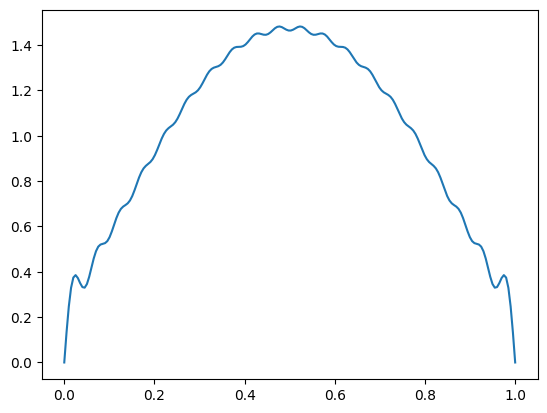

Entropy: -0.09094970456349262 0.06198434198138371
Integrate: 0.9999999999997387
1 Order Moment: 0.5000000000001186 1.1857181902996672e-13
2 Order Moment: 0.303879694860528 0.31716505147932905
3 Order Moment: 0.2058195422907327 0.36091441177007527
4 Order Moment: 0.14965552479807118 0.3222410773768523
5 Order Moment: 0.1144395748439765 0.31011888299674684
6 Order Moment: 0.09086400438312126 0.40078949710328204
 
Loop: 2
a value:
1.5104560127436362,0.06824159600327563,0.06014791614747441,0.04870447322967726,0.03947188217601274,0.03296041435899721,0.028275477980960854,0.024787372325151456,0.02211258354207709,0.020010510860332925,0.01832321014833919,0.0169452708393546,0.015802165024070683,0.014840444885052729,0.01402757196073659,0.013345555724174908,0.012803597493831904,0.012463727418346704,0.012649597222451675,0.017054055279184775
Lambda:
1.7991448277843922


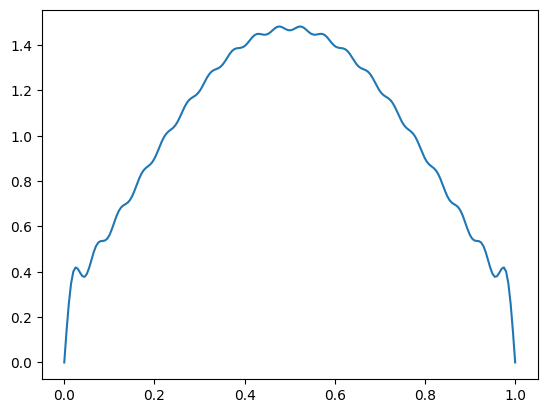

Entropy: -0.085228838196935 0.005720866366557623
Integrate: 1.0000000000002371
1 Order Moment: 0.5000000000000023 2.3314683517128287e-15
2 Order Moment: 0.30472075936215126 0.3410793108373969
3 Order Moment: 0.20708113904322578 0.3867581190588772
4 Order Moment: 0.15112899573458002 0.3537199835622824
5 Order Moment: 0.11602059093107413 0.344114403785143
6 Order Moment: 0.09249328668949057 0.44532268501688005
 
Loop: 3
a value:
1.5102544528295403,0.06822631847959897,0.06033481075967986,0.04901776564803262,0.03987094051903483,0.033367636162781725,0.0286494442571898,0.02510664222592615,0.022362881381253988,0.020183109652852256,0.018415537096640337,0.016959087399219554,0.015745086555376927,0.014726647518778129,0.013873412601418339,0.013170385059253066,0.012623815858570211,0.01229096546162899,0.012495613414221132,0.01690397278590358
Lambda:
1.7994643585992192


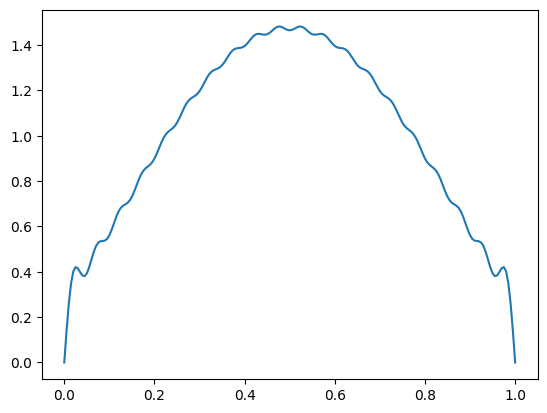

Entropy: -0.08506001769853781 0.00016882049839718472
Integrate: 1.0000000000000047
1 Order Moment: 0.5000000000000006 5.551115123125783e-16
2 Order Moment: 0.30474637327933624 0.34180759963992674
3 Order Moment: 0.20711955991900416 0.3875451675872074
4 Order Moment: 0.15117422643857828 0.3546862822876821
5 Order Moment: 0.11606963289810555 0.34516892006952904
6 Order Moment: 0.0925444088742249 0.44672000815138374
 
Loop: 4
a value:
1.5102541270655774,0.06822597482655605,0.060335224712124456,0.04901847920970946,0.0398718238064649,0.033368600229418295,0.02865040494271628,0.025107514851074906,0.022363598506762533,0.02018361387712523,0.018415802319702856,0.016959100883299487,0.015744860222062694,0.014726218902581356,0.013872821960908128,0.013169696026174089,0.012623086154232218,0.012290249392456033,0.01249494619147898,0.016903280942178994
Lambda:
1.7994653866992663


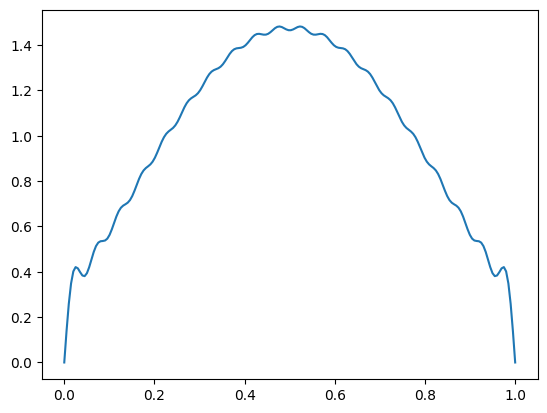

Entropy: -0.08505972864838185 2.8905015596325523e-07
Integrate: 1.0000000000000009
1 Order Moment: 0.5 0.0
2 Order Moment: 0.3047464158983576 0.3418088114403637
3 Order Moment: 0.20711962384753643 0.387546477158013
4 Order Moment: 0.1511743030082837 0.35468791810588085
5 Order Moment: 0.11606971777481513 0.3451707451160725
6 Order Moment: 0.09254449924962753 0.44672247838307566
 
Converge!
a_value:
1.5102541270655774,0.06822597482655605,0.060335224712124456,0.04901847920970946,0.0398718238064649,0.033368600229418295,0.02865040494271628,0.025107514851074906,0.022363598506762533,0.02018361387712523,0.018415802319702856,0.016959100883299487,0.015744860222062694,0.014726218902581356,0.013872821960908128,0.013169696026174089,0.012623086154232218,0.012290249392456033,0.01249494619147898,0.016903280942178994
a_change: [-0.00000033 -0.00000034  0.00000041  0.00000071  0.00000088  0.00000096
  0.00000096  0.00000087  0.00000072  0.0000005   0.00000027  0.00000001
 -0.00000023 -0.00000043 -0.000

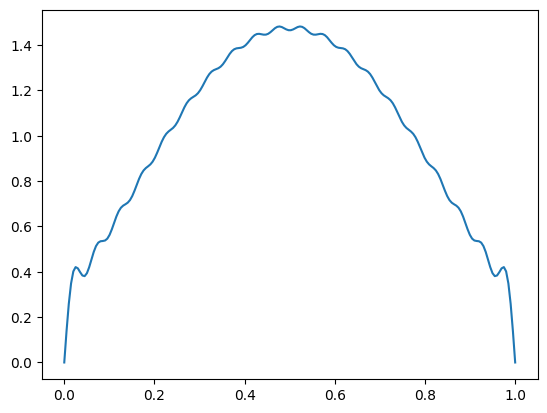

Entropy: -0.08505972864838185 2.8905015596325523e-07
Integrate: 1.0000000000000009
1 Order Moment: 0.5 0.0
2 Order Moment: 0.3047464158983576 0.3418088114403637
3 Order Moment: 0.20711962384753643 0.387546477158013
4 Order Moment: 0.1511743030082837 0.35468791810588085
5 Order Moment: 0.11606971777481513 0.3451707451160725
6 Order Moment: 0.09254449924962753 0.44672247838307566
 


In [5]:
mu = [0.5, 0.292725, 0.188201, 0.134572, 0.100017, 0.0762008]
sigma = [1, 0.03517, 0.0488164, 0.0468082, 0.0465066, 0.0365858]
a_coefficient = [1.5874359880444386,-0.08755882521808671,0.004302418781726984,0.01625154345403754,0.015844935375033113,0.01384197958829626,0.01173857816610417,0.009623562988438418,0.007113161974164537,0.009531896610637174,0.009552846816581823,0.013084793589671309,0.012889104957049062,0.012237172734995075,0.011567614741438102,0.01097942581673839,0.010530979823644432,0.01029094264108881,0.01058314196190316,0.0139400520729469]
beta = 0.01
s, a_coefficient, moment, freq = SCF(a_coefficient)